# How happiness score relates to development indicators ?

In this notebook, we analyse the link between the happiness score as reported by the World Happiness Report ([official website](http://worldhappiness.report/), [wiki](https://fr.wikipedia.org/wiki/World_Happiness_Report)) and [world development indicators compiled by the world bank](http://datatopics.worldbank.org/world-development-indicators/).  
  
Data were directly downloaded from 2 kaggle datasets :  
- [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness) which ranks 155 countries by happiness score
- [World Development Indicators](https://www.kaggle.com/worldbank/world-development-indicators) which contains 932 indicators for 138 countries

The happiness scores and rankings use data from the Gallup World Poll. The scores are based on answers to the main life evaluation question asked in the poll.  
  


# 0 - Download Data

In [8]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('unsdsn/world-happiness', path='./data', unzip=True)
kaggle.api.dataset_download_files('worldbank/world-development-indicators', path='./data', unzip=True)

In [9]:
!ls data/

2015.csv         Country.csv      Indicators.csv   database.sqlite
2016.csv         CountryNotes.csv Series.csv       hashes.txt
2017.csv         Footnotes.csv    SeriesNotes.csv


# 1- Merge happiness and development datasets

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pprint

# Display options and routine
# ---------------------------
#plt.style.use('../my_theme/argos3.mplstyle')
pd.set_option('max_rows', 20000)

pd.set_option('max_rows', 20000)
pd.set_option('max_columns', 200)
pd.set_option('max_colwidth', 200)

def bprint(text, *args):
    '''Print in bold :'''
    if args:
        print('\033[1m' + text + '\033[0m', *args)
    else:
        print('\033[1m' + text + '\033[0m')
    

def a(n=5):
    '''Fast-typing head priting of dataset'''
    # Put your main dataframe here :
    return df_data.head(n)


print('Loading data...')

df_happiness = pd.read_csv('./data/2015.csv')
df_economics = pd.read_csv('./data/Indicators.csv')
df_countries = pd.read_csv('./data/Country.csv')

print('ok')

Loading data...
ok


**Countries have different names in World Happiness Dataset and World Development Dataset. See :  **

In [15]:
search_for = 'Slovak'
print("Found : '", df_happiness.Country[df_happiness.Country.str.contains(search_for)].values[0], "' in happiness dataset")
print("Found : '", df_economics.CountryName[df_economics.CountryName.str.contains(search_for)].iloc[0], "' in development dataset")

Found : ' Slovakia ' in happiness dataset
Found : ' Slovak Republic ' in development dataset


** ...so, we need to align these names before we merge the 2 datasets : **

In [16]:
print('Aligning countries names between the 2 datasets...')
countries_in_eco = pd.Series(df_economics.CountryName.unique())
countries_in_happy = pd.Series(df_happiness.Country.unique())

print("\t> There are ", countries_in_happy.isin(countries_in_eco).sum(), \
      'common countries in the 2 datasets out of ', countries_in_happy.shape[0], 'in happiness data')

# This dict was build by searching substring of country names in both datasets :
eco2happy_countries = {
    'Slovak Republic': 'Slovakia',
    'Russian Federation': 'Russia',
    'Korea, Rep.': 'South Korea',
    'Cyprus': 'North Cyprus',
    'Hong Kong SAR, China': 'Hong Kong',
    'Venezuela, RB': 'Venezuela',
    'Macedonia, FYR': 'Macedonia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Egypt, Arab Rep.': 'Egypt',
    'Iran, Islamic Rep.': 'Iran',
    'Congo, Dem. Rep.': 'Congo (Kinshasa)',
    'Congo, Rep.': 'Congo (Brazzaville)',
    'Cote d\'Ivoire': 'Ivory Coast',
    'Yemen, Rep.': 'Yemen',
    'Syrian Arab Republic': 'Syria'
}

# Sanity check : no countries missing :
for ecoc, hapc in eco2happy_countries.items():
    if countries_in_eco.isin([ecoc]).sum() == 0:
        print('\t> WARNING - Missing : ', ecoc, ' in economic data')
    if countries_in_happy.isin([hapc]).sum() == 0:
        print('\t> WARNING - Missing : ', hapc, ' in happiness data')

# Align country names :
df_economics.rename(eco2happy_countries, index='index', inplace=True)

print('Countries are now aligned')

Aligning countries names between the 2 datasets...
	> There are  139 common countries in the 2 datasets out of  158 in happiness data
Countries are now aligned


** The World Development Indicator dataset contains one row per indicator, but the following format is preferable : ** 
- **rows** : countries
- **columns** : indicators
  
** We need to pivot the WDI table : **

In [17]:
studied_year = 2014  # 2015 has not enough indicators !!

indicators_names = (df_economics[df_economics.Year == studied_year]['IndicatorName'].unique().tolist())
indicators_codes = (df_economics[df_economics.Year == studied_year]['IndicatorCode'].unique().tolist())

indicators_to_codes = dict()
codes_to_indicators = dict()
for a, b in zip(indicators_names, indicators_codes):
    indicators_to_codes[a] = b
    codes_to_indicators[b] = a
    
economics = df_economics[df_economics.Year == studied_year]. \
    pivot_table(columns=['IndicatorCode'], values=['Value'], index=['CountryName'])


economics.columns = economics.columns.droplevel(None)

** We can now merge the 2 datasets : **

In [18]:
df_happiness.set_index('Country', inplace=True)

df_data = pd.merge(df_happiness, economics, left_index=True, right_index=True)

# Add country codes :
df_codes = df_economics[['CountryName', 'CountryCode']].\
        drop_duplicates(). \
        set_index('CountryName'). \
        rename(eco2happy_countries, index='index')

df_data = pd.merge(df_codes, df_data, left_index=True, right_index=True)

# 2 - Build a data dictionnary

** In the WDI dataset, indicators are encoded. The table from 'Series.csv' gives the correspondance with topics and indicator name.**  
  
**For example 'EN.URB.LCTY' stands for EN=Environment, URB=Urbanisme and LCTY=population in largest city**  
  
**See : **

In [22]:
df_nomanclature = pd.read_csv('./data/Series.csv')

df_nomanclature[['SeriesCode', 'Topic', 'IndicatorName']].query('SeriesCode == "EN.URB.LCTY"')

,SeriesCode,Topic,IndicatorName
629,EN.URB.LCTY,Environment: Density & urbanization,Population in largest city


** We need to be able to retrieve quickly these information during exploration, espacially :**
- **  Translate a code (our dataset columns) into a meaningfull description **
- ** For each code gets its topics (trade, environment...) and subtopics **
- **  Get all indicators and codes for a given topic **  
  
** In the following, we build a dataframe of topics : **

In [24]:
import re

topics = set()
code_topics = dict()

for topic, code in zip(df_nomanclature.Topic, df_nomanclature.SeriesCode):
    re_topics = re.findall('([A-Z]([\w :,](& [a-z]+)*)*(?= & )?)', topic)
    matches = [ret[0].strip() for ret in re_topics]
    if len(matches)==0:
        print('warning : ', topic)

    code_topics[code] = [] # each indicator has multiple topics
    for new_topic in matches:
        sub_topics = re.findall('[A-Za-z &]+', new_topic) 
        if len(sub_topics)==0:
            print('warning : ', sub_topics)
        topics.add(sub_topics[0])
        code_topics[code] += [sub_topics[0]]

df_topics = pd.DataFrame(np.zeros([df_data.shape[1]-12, len(topics)+1]),\
                         index=df_data.columns[12:].tolist(), columns=['Desc'] + list(topics))

for codename in df_topics.index.tolist():
    df_topics.loc[codename, 'Desc'] = codes_to_indicators[codename]
    for c in code_topics[codename]:
        df_topics.loc[codename, c] = int(1)

for t in list(topics):
    df_topics[t] = df_topics[t].astype('int')
    
pd.set_option('max_colwidth', 20)
df_topics.sample(2)

,Desc,GNI per capita,Poverty,Debt,Education,Environment,Trade,Private Sector,Public Sector,Health,Expenditure on GDP,Infrastructure,Social Protection,Other items,Labor,Economic Policy,Value added,Financial Sector,Aggregate indicators
NE.CON.PRVT.PC.KD,Household final ...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
BX.GSR.TRVL.ZS,Travel services ...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Example of usages :

In [25]:
bprint('Code EN.URB.LCTY is : ', df_topics.loc['EN.URB.LCTY'].Desc)
bprint('Also code EN.URB.LCTY is : ', codes_to_indicators['EN.URB.LCTY'])
bprint('Topic of code EN.URB.LCTY is : ', df_topics.columns[df_topics.loc['EN.URB.LCTY']==1][0])
bprint('Example of 3 Trade indicators : ', df_topics[df_topics.Trade==1].index.tolist()[0:3])

Code EN.URB.LCTY is :  Population in largest city
Also code EN.URB.LCTY is :  Population in largest city
Topic of code EN.URB.LCTY is :  Environment
Example of 3 Trade indicators :  ['IC.BUS.DFRN.XQ', 'IC.BUS.DISC.XQ', 'IC.BUS.EASE.XQ']


# 3 - Linear model + feature selection

Recall that we want to find if there is a relation between the happiness score (HS) and development indicators (DI).   

** We are going to fit linear models to measure by how much development indicators impact the happiness score  
There might be strong multicolinearity because economic and social indicators are somehow redondant.  
Moreover, p (nb features) >> n (nb samples) so standard linear regression won't work.  ** 

We will evaluate several methods for this tasks :
- intuitive selection of variables
- lasso regression

*** Preprocessing : just drop variables with too many na values ***

In [27]:
remove_happy_cols = df_happiness.columns.tolist()
remove_happy_cols.remove('Happiness Score')

df_data_ols = df_data.drop(remove_happy_cols, axis=1). \
            loc[:,df_data.isnull().sum() < 10]. \
            fillna(method='ffill')

In [29]:
bprint('Working with : ', df_data_ols.shape[0], ' samples and ', df_data_ols.shape[1], ' variables')

Working with :  138  samples and  159  variables


## Method 1 : manual selection of variables

In this section, we manualy select variables based on our intuition of which indicator might impact happiness. We also evaluate multicolinearity to remove redondant information.  
  
Our strategy : 
- group variables by groups of topics
- compute the VIF for each group and remove variables with high VIF and redondant information
- rerun the VIF to check for multicolinearity again

The rationale behind running a VIF analysis within each group is to simplify analysis : if multicolinearity exist it might be mainly present within group of similar indicators

### 1.1 Multicolinearity analysis :

** We first illustrate the colinearity between 2 predictors and how it affects the least square coefficients :**

Predictor is :  Proportion of seats held by women in national parliaments (%)
F-statics p value :  3.8362072589835855e-48
Coefficient for SG.GEN.PARL.ZS is  0.1998210877632385  with p-value :  3.836207258983629e-48

Predictor is :  Labor force, female (% of total labor force)
F-statics p value :  9.516564216914192e-72
Coefficient for SL.TLF.TOTL.FE.ZS is  0.12448009951037814  with p-value :  9.516564216914265e-72

Now with both predictors :
F-statics p value :  2.8993290103064176e-72
Coefficient for SL.TLF.TOTL.FE.ZS is  0.04158998782913078  with p-value :  0.001594716320096239
Coefficient for SL.TLF.TOTL.FE.ZS is  0.10280931176305128  with p-value :  2.368462878863951e-27


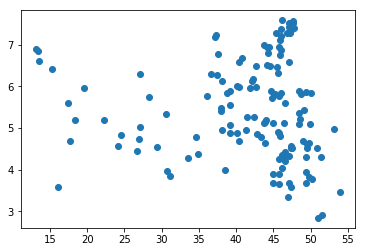

In [30]:
import statsmodels.api as sm

predictors = ['SG.GEN.PARL.ZS', 'SL.TLF.TOTL.FE.ZS']

# First predictor
bprint('Predictor is : ', codes_to_indicators[predictors[0]])

model = sm.OLS(df_data_ols['Happiness Score'], df_data_ols.loc[:,predictors[0]])
res = model.fit()

bprint("F-statics p value : ", res.f_pvalue)
bprint("Coefficient for SG.GEN.PARL.ZS is ",  res.params[0], ' with p-value : ', res.pvalues[0])

# Second predictor
bprint('\nPredictor is : ', codes_to_indicators['SL.TLF.TOTL.FE.ZS'])

model = sm.OLS(df_data_ols['Happiness Score'], df_data_ols.loc[:,predictors[1]])
res = model.fit()

bprint("F-statics p value : ", res.f_pvalue)
bprint("Coefficient for SL.TLF.TOTL.FE.ZS is ",  res.params[0], ' with p-value : ', res.pvalues[0])



# Second predictor
bprint('\nNow with both predictors :')

model = sm.OLS(df_data_ols['Happiness Score'], df_data_ols.loc[:,predictors])
res = model.fit()

bprint("F-statics p value : ", res.f_pvalue)
bprint("Coefficient for SL.TLF.TOTL.FE.ZS is ",  res.params[0], ' with p-value : ', res.pvalues[0])
bprint("Coefficient for SL.TLF.TOTL.FE.ZS is ",  res.params[1], ' with p-value : ', res.pvalues[1])

plt.plot(df_data_ols.loc[:,predictors[1]], df_data_ols['Happiness Score'], 'o');

** As we can see, coefficients tend to change depending on which predictors is used **
  
** We can confirm that by computing the variance inflation factor for the 2 variables : **

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

print(variance_inflation_factor(df_data_ols.loc[:,predictors].values, 0))
print(variance_inflation_factor(df_data_ols.loc[:,predictors].values, 1))

5.049136249165473
5.049136249165473


A VIF > 5 indicates strong multicolinearity

### 1.2 Selecting good features by intuitive analysis

In [33]:
final_indicators = []

#### Groups of topics :

In [34]:
eco_ind = ['Trade', 'Private Sector', 'Poverty', 'GNI per capita', 'Aggregate indicators', 'Expenditure on GDP', 'Financial Sector', 'Debt', 'Labor', 'Economic Policy']
social_ind = ['Education', 'Social Protection', 'Health', ]
other_ind = ['Environment', 'Other items']
public_ind = ['Public Sector', 'Infrastructure']

#### Analysis for public indicator group : 

In [35]:
bprint('Public sector VIF : ')
select_indicators = (df_topics[public_ind]==1).sum(axis=1)>0
predictors = df_topics[select_indicators].index
predictors = df_data_ols.columns[df_data_ols.columns.isin(predictors)].tolist()
for i in range(len(predictors)):
    print(predictors[i], ' ', codes_to_indicators[predictors[i]])
    print(variance_inflation_factor(df_data_ols.loc[:,predictors].values, i))

Public sector VIF : 
EP.PMP.DESL.CD   Pump price for diesel fuel (US$ per liter)
55.69445880288566
EP.PMP.SGAS.CD   Pump price for gasoline (US$ per liter)
61.23236910762563
IT.CEL.SETS   Mobile cellular subscriptions
4.411664875811659
IT.CEL.SETS.P2   Mobile cellular subscriptions (per 100 people)
9.499339256640043
IT.MLT.MAIN   Fixed telephone subscriptions
55.479287371010216
IT.MLT.MAIN.P2   Fixed telephone subscriptions (per 100 people)
8.190829127726307
IT.NET.BBND   Fixed broadband subscriptions
44.1594303000055
IT.NET.SECR   Secure Internet servers
1.9082351323625335
IT.NET.SECR.P6   Secure Internet servers (per 1 million people)
2.837411092701345
IT.NET.USER.P2   Internet users (per 100 people)
13.69467876750331
SG.GEN.PARL.ZS   Proportion of seats held by women in national parliaments (%)
5.04163332390664


**We use our knowledge to remove redondant information.  
For example : ** mobile cellular subscription and internet users are correlated since one technology often comes with the other in a country.

In [36]:
predictors = ['SG.GEN.PARL.ZS', 'IT.NET.USER.P2']
for i in range(len(predictors)):
    print(predictors[i], ' ', codes_to_indicators[predictors[i]])
    print(variance_inflation_factor(df_data_ols.loc[:,predictors].values, i))

SG.GEN.PARL.ZS   Proportion of seats held by women in national parliaments (%)
2.5373014789346278
IT.NET.USER.P2   Internet users (per 100 people)
2.5373014789346278


In [37]:
final_indicators += predictors

#### Social indicators :   

In [38]:
social_codes = ['SH.DTH.AGGREGATE']

# Aggregates deaths :
mortality_cols = ['SH.DTH.IMRT', 'SH.DTH.MORT' , 'SH.DTH.NMRT', 'SH.DYN.MORT', 'SH.DYN.NMRT']
df_data_ols['SH.DTH.AGGREGATE'] = 0
codes_to_indicators['SH.DTH.AGGREGATE'] = 'Sum of all normalized number of death indicators'
for col in mortality_cols: 
    df_data_ols['SH.DTH.AGGREGATE'] += (df_data_ols[col]-df_data_ols[col].mean()) / df_data_ols[col].std()

# Keep one education entrance/duration indicator :
social_codes += ['SE.SEC.AGES']

# Keep the most global water access indicator :
social_codes += ['SH.H2O.SAFE.ZS']

# Do not keep immunization indicators : accounted in death stats

# Lifetime risk of maternal death: 
social_codes += ['SH.MMR.RISK.ZS']

# Keep the most global sanitation acces indicator :
social_codes += ['SH.STA.ACSN']

# Diabetes :
social_codes += ['SH.STA.DIAB.ZS']

# Employment : remove redondant stats
# Keep : % unemployment + ratio female/male in active popoulation
social_codes += [ 'SL.TLF.CACT.FM.ZS', 'SL.UEM.TOTL.ZS']

# Refuees :
social_codes += ['SM.POP.REFG', 'SM.POP.REFG.OR']

# Adolescent fertility
social_codes += ['SP.ADO.TFRT']

# Population age 0-14 as a single indicator of pop distribution
social_codes += ['SP.POP.0014.TO.ZS']

# Population growth annual
social_codes += ['SP.POP.GROW']

In [39]:
bprint('Socio-demographic VIFs : ')
for i in range(len(social_codes)):
    print(social_codes[i], ' ', codes_to_indicators[social_codes[i]])
    print(variance_inflation_factor(df_data_ols.loc[:,social_codes].values, i))

Socio-demographic VIFs : 
SH.DTH.AGGREGATE   Sum of all normalized number of death indicators
1.8593919853444465
SE.SEC.AGES   Official entrance age to lower secondary education (years)
157.80180891648112
SH.H2O.SAFE.ZS   Improved water source (% of population with access)
110.29585075962572
SH.MMR.RISK.ZS   Lifetime risk of maternal death (%)
5.3542245085814075
SH.STA.ACSN   Improved sanitation facilities (% of population with access)
42.63943444880579
SH.STA.DIAB.ZS   Diabetes prevalence (% of population ages 20 to 79)
6.450945608699151
SL.TLF.CACT.FM.ZS   Ratio of female to male labor force participation rate (%) (modeled ILO estimate)
28.43020126937787
SL.UEM.TOTL.ZS   Unemployment, total (% of total labor force)
3.4454767361726937
SM.POP.REFG   Refugee population by country or territory of asylum
1.3508739577992046
SM.POP.REFG.OR   Refugee population by country or territory of origin
1.2278775429906514
SP.ADO.TFRT   Adolescent fertility rate (births per 1,000 women ages 15-19)
9.3

** Now we remove highest VIF one by one and check each time : **

In [40]:
social_codes.remove('SE.SEC.AGES')
social_codes.remove('SH.H2O.SAFE.ZS')
social_codes.remove('SH.STA.ACSN')
social_codes.remove('SP.POP.0014.TO.ZS')
social_codes.remove('SL.TLF.CACT.FM.ZS')
social_codes.remove('SP.ADO.TFRT')

In [41]:
for i in range(len(social_codes)):
    print(social_codes[i], ' ', codes_to_indicators[social_codes[i]])
    print(variance_inflation_factor(df_data_ols.loc[:,social_codes].values, i))

SH.DTH.AGGREGATE   Sum of all normalized number of death indicators
1.4798366522423156
SH.MMR.RISK.ZS   Lifetime risk of maternal death (%)
2.5770897595445885
SH.STA.DIAB.ZS   Diabetes prevalence (% of population ages 20 to 79)
2.982759424807645
SL.UEM.TOTL.ZS   Unemployment, total (% of total labor force)
2.0349507059254366
SM.POP.REFG   Refugee population by country or territory of asylum
1.1645761922195774
SM.POP.REFG.OR   Refugee population by country or territory of origin
1.0950642512458548
SP.POP.GROW   Population growth (annual %)
3.368757613597416


In [42]:
final_indicators += social_codes

#### Economic indicators :

In [43]:
economic_codes = []

# LOGISTIC indicator => Sum all logistic index :
df_data_ols['LP.LPI.SUM'] = 0
log_index = ['LP.LPI.CUST.XQ', 'LP.LPI.INFR.XQ', 'LP.LPI.ITRN.XQ', 'LP.LPI.LOGS.XQ', 'LP.LPI.OVRL.XQ', 'LP.LPI.TIME.XQ']
for c in log_index:
    df_data_ols['LP.LPI.SUM'] += df_data_ols[c]
economic_codes += ['LP.LPI.SUM']
codes_to_indicators['LP.LPI.SUM'] = 'Sum of all logistic indicators (Ours)'
codes_to_indicators['Sum of all logistic indicators (Ours)'] = 'LP.LPI.SUM'

# GDP : keep one indicator
economic_codes += ['NY.GDP.PCAP.CN']   #GDP per capita (current LCU)

# Employment : already accounted in social indicators

# GDP per capita (current LCU)
economic_codes += ['NY.GDP.MKTP.KD.ZG', 'NY.GDP.MKTP.CN', 'NY.GDP.DEFL.ZS', 'NY.GDP.DEFL.KD.ZG']

# Import / export => We selected the following variables by running an iterative VIF analysis :
economic_codes += ['TG.VAL.TOTL.GD.ZS', 'TM.VAL.MRCH.CD.WT', 'TM.VAL.MRCH.R4.ZS', 'TM.VAL.MRCH.RS.ZS']

In [44]:
for i in range(len(economic_codes)):
    print(economic_codes[i], ' ', codes_to_indicators[economic_codes[i]])
    print(variance_inflation_factor(df_data_ols.loc[:,economic_codes].values, i))

LP.LPI.SUM   Sum of all logistic indicators (Ours)
0.29351208006164553
NY.GDP.PCAP.CN   GDP per capita (current LCU)
1.7423005526459632
NY.GDP.MKTP.KD.ZG   GDP growth (annual %)
1.1253563941045392
NY.GDP.MKTP.CN   GDP (current LCU)
1.5726576189510846
NY.GDP.DEFL.ZS   GDP deflator (base year varies by country)
1.1801282551800514
NY.GDP.DEFL.KD.ZG   Inflation, GDP deflator (annual %)
1.207456221623425
TG.VAL.TOTL.GD.ZS   Merchandise trade (% of GDP)
1.1965609861246953
TM.VAL.MRCH.CD.WT   Merchandise imports (current US$)
1.220121839718222
TM.VAL.MRCH.R4.ZS   Merchandise imports from developing economies in Middle East & North Africa (% of total merchandise imports)
1.0650191776808988
TM.VAL.MRCH.RS.ZS   Merchandise imports by the reporting economy, residual (% of total merchandise imports)
1.0718194859136707


In [45]:
final_indicators += economic_codes

** Final check : **

In [47]:
for i in range(len(final_indicators)):
    v = variance_inflation_factor(df_data_ols.loc[:,final_indicators].values, i)
    print(final_indicators[i], ' ', codes_to_indicators[final_indicators[i]], ' ', v)

SG.GEN.PARL.ZS   Proportion of seats held by women in national parliaments (%)   1.1846468687917084
IT.NET.USER.P2   Internet users (per 100 people)   4.046478707902986
SH.DTH.AGGREGATE   Sum of all normalized number of death indicators   1.795528655102063
SH.MMR.RISK.ZS   Lifetime risk of maternal death (%)   2.4544172496523924
SH.STA.DIAB.ZS   Diabetes prevalence (% of population ages 20 to 79)   1.148860340133786
SL.UEM.TOTL.ZS   Unemployment, total (% of total labor force)   1.1800153711236174
SM.POP.REFG   Refugee population by country or territory of asylum   1.1292281635668289
SM.POP.REFG.OR   Refugee population by country or territory of origin   1.109743372635582
SP.POP.GROW   Population growth (annual %)   1.5956300722537944
LP.LPI.SUM   Sum of all logistic indicators (Ours)   1.3912019902164072
NY.GDP.PCAP.CN   GDP per capita (current LCU)   1.8215956732738146
NY.GDP.MKTP.KD.ZG   GDP growth (annual %)   1.4519940551933657
NY.GDP.MKTP.CN   GDP (current LCU)   1.70149372108997

** We have selected 19 features. We can now run a linear regression **

### 3.3 Fit a linear regression on selected indicators : 

In [48]:
df_data_ols = sm.add_constant(df_data_ols)
model = sm.OLS(df_data_ols['Happiness Score'], df_data_ols[final_indicators + ['const']])
res = model.fit()
print('R squared : ', res.rsquared)
print('R squared adjusted : ', res.rsquared_adj)

R squared :  0.5951395513405799
R squared adjusted :  0.5562729482692756


In [49]:
bprint("Significant variables are : ")
significant_variables = []
for c in final_indicators:
    pvalue = res.pvalues[c]
    if pvalue < 0.05:
        print(codes_to_indicators[c], ' - ', c, ' -  with coef : ', res.params[c])
        significant_variables.append(c)

Significant variables are : 
Internet users (per 100 people)  -  IT.NET.USER.P2  -  with coef :  0.014486620195759983
Diabetes prevalence (% of population ages 20 to 79)  -  SH.STA.DIAB.ZS  -  with coef :  0.06126410822684193
Sum of all logistic indicators (Ours)  -  LP.LPI.SUM  -  with coef :  0.22564296441294035


In [50]:
def plot_regression(data, ind_var, dep_var, model, ax=plt):
    X = data.loc[:, ind_var]
    ax.plot(X, data[dep_var], 'o')
    xgrid = np.linspace(X.min(), X.max(), 50)
    ax.plot(xgrid, model.params['const'] + model.params[c] * xgrid, 'r')

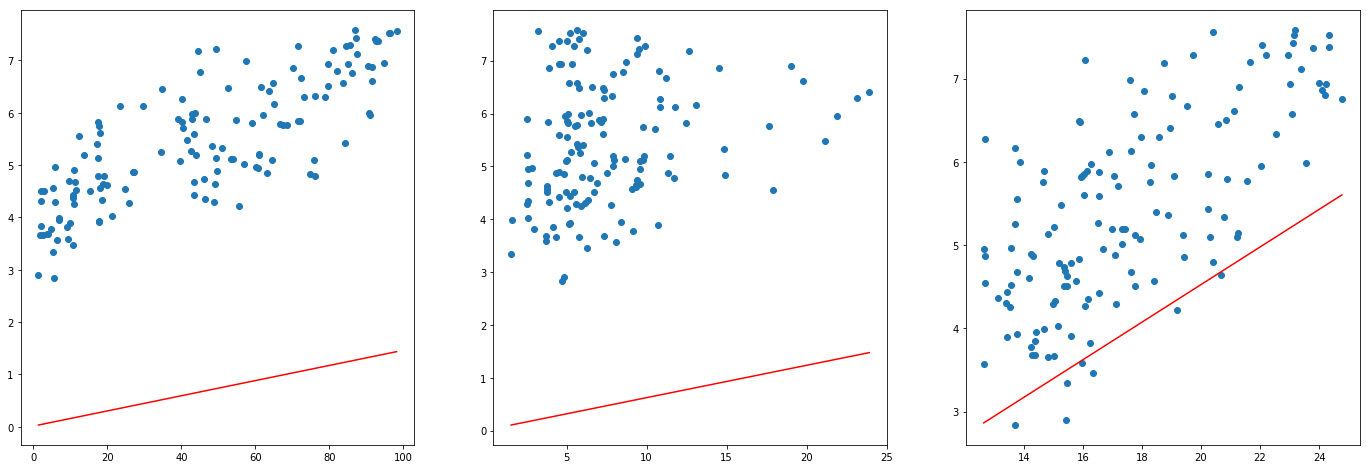

In [52]:
plt.figure(figsize=(24,8))

for i, c in enumerate(significant_variables):
    plt.subplot(1, 3, i+1)
    plot_regression(df_data_ols, c, 'Happiness Score', res)

plt.show()

** We then procede to a qualitative evaluation of these results by displaying maps. **  
  
** Load polygons of world countries : **

In [56]:
import geopandas as gpd

world_map = gpd.read_file('./data/countries.json')

** Align countries names in data and in map :**

In [57]:
print('Aligning countries names between the 2 datasets...')
countries_in_data = pd.Series(df_data_ols.index.unique())
countries_in_map = pd.Series(world_map.name.unique())

print("\t> There are ", countries_in_map.isin(countries_in_data).sum(), \
      'common countries in the 2 datasets out of ', df_data_ols.shape[0], 'in happiness data')

#bprint('Missing countries : ', countries_in_data[~countries_in_data.isin(countries_in_map)])

countries_map_to_data = {
    'Republic of Serbia': 'Serbia',
    'United Republic of Tanzania': 'Tanzania',
    'United States of America': 'United States'
}

# Sanity check : no countries missing :
for ecoc, hapc in countries_map_to_data.items():
    if countries_in_map.isin([ecoc]).sum() == 0:
        print('\t> WARNING - Missing : ', ecoc, ' in economic data')
    if countries_in_data.isin([hapc]).sum() == 0:
        print('\t> WARNING - Missing : ', hapc, ' in happiness data')

# Align country names :
world_map.set_index('name', inplace=True)
world_map.rename(countries_map_to_data, index='index', inplace=True)

print('Countries are now aligned')

Aligning countries names between the 2 datasets...
	> There are  130 common countries in the 2 datasets out of  138 in happiness data
Countries are now aligned


** Cloropeth map : **

In [59]:
def plot_map(world_map_with_data, c, ax):
    c_mean = world_map_with_data[c].mean()
    c_std = world_map_with_data[c].std()
    world_map_with_data.plot(column=c, cmap='Blues', \
                             linewidth=0.8, ax=ax, edgecolor='0.8', \
                             vmax=c_mean + 2* c_std, \
                             vmin=c_mean - 2* c_std                      
                            );
    if c in codes_to_indicators:
        ax.set_title(codes_to_indicators[c], fontsize=12)
    else:
        ax.set_title(c, fontsize=12)

** Merge data and map polygons then display : **

/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


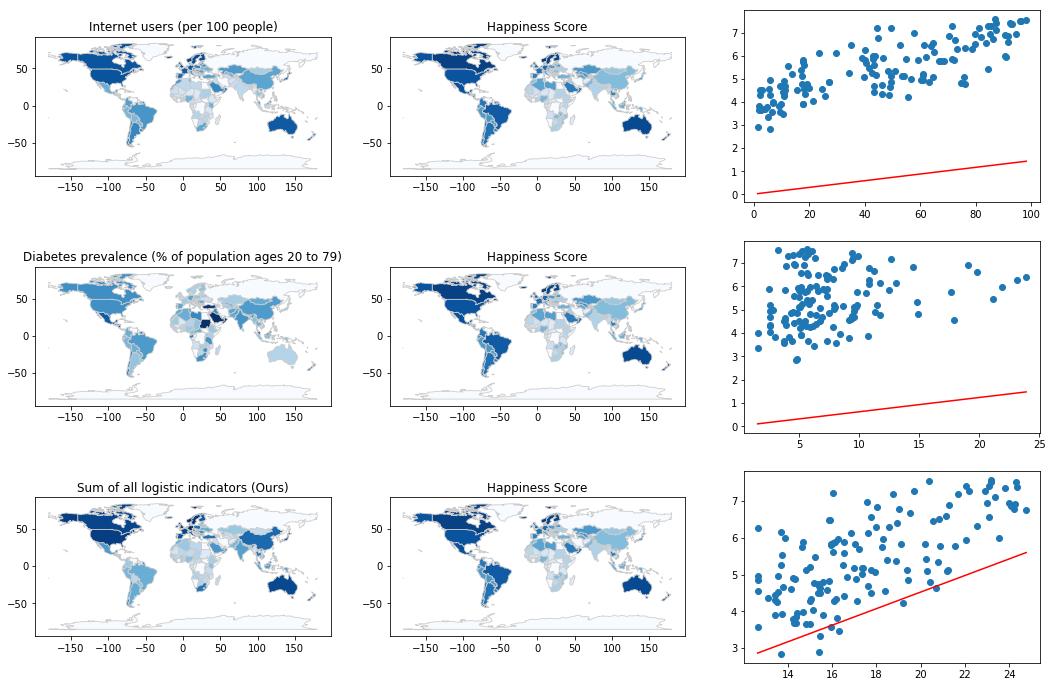

In [60]:
world_map_with_data = world_map.join(df_data_ols)

fig, ax = plt.subplots(len(significant_variables), 3, figsize=(18, 12));

for i, c in enumerate(significant_variables):
    
    plot_map(world_map_with_data, c, ax[i][0])

    plot_map(world_map_with_data, 'Happiness Score', ax[i][1])

    plot_regression(df_data_ols, c, 'Happiness Score', res, ax[i][2])

Happinness map and the 3 selected indicators map superimpose


## Method 2 : automatic selection of features with lasso

Lasso :
- select features
- remove multicolinearity

In [61]:
all_indicators = df_data_ols.columns.tolist()
all_indicators.remove('Happiness Score')
all_indicators.remove('CountryCode')

** Run a cross validation to choose the optimal regularization term, plot MSE as a function of alpha and plot maps of the indicators for best alpha : **

Cross validation for hyperparameter tuning...
Best MSE :  0.8281531415516089
Best alpha :  8.286427728546842
Non zeros coefficients : 
['Average precipitation in depth (mm per year)', 'Time required to get electricity (days)', 'Time to prepare and pay taxes (hours)', 'Secure Internet servers (per 1 million people)', 'Maternal mortality ratio (modeled estimate, per 100,000 live births)']
Coefs :  [0.0002177204869284286, -0.00032129668043767424, 0.0002884586541064691, 0.00035866355487936354, -0.0012555167910529449]
Display maps...


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


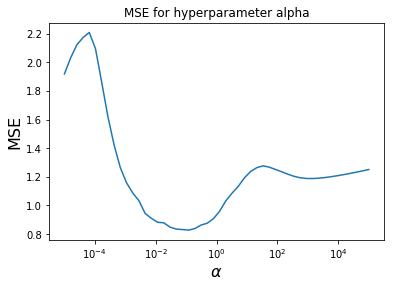

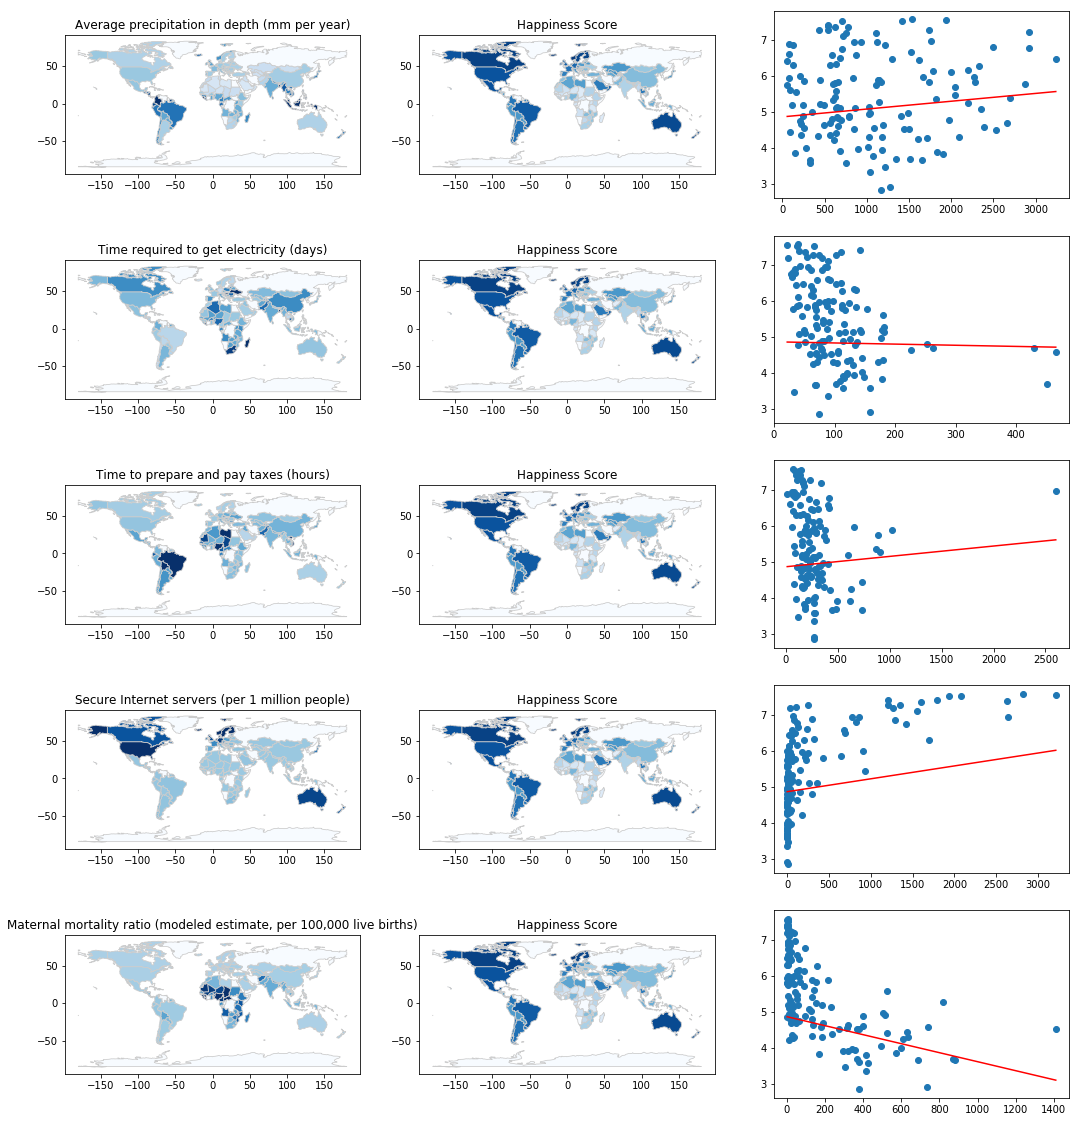

In [72]:
from sklearn.linear_model import LassoCV

bprint('Cross validation for hyperparameter tuning...')
mdl = LassoCV(alphas=np.logspace(-5,5), tol=1, cv=3)

mdl.fit(df_data_ols[all_indicators], df_data_ols['Happiness Score'])

plt.plot(mdl.alphas, mdl.mse_path_.mean(axis=1));
plt.xscale('log')
plt.title('MSE for hyperparameter alpha')
plt.ylabel('MSE', fontsize=16);
plt.xlabel(r'$\alpha$', fontsize=16);

bprint('Best MSE : ', mdl.mse_path_.mean(axis=1).min())
bprint('Best alpha : ', mdl.alpha_)
bprint('Non zeros coefficients : ')

lasso_codes = [x for x, y in zip(all_indicators, mdl.coef_) if np.abs(y) > 0.0001]
lasso_idx = [x for x, y in enumerate(mdl.coef_) if np.abs(y) > 0.0001]
lasso_indicators = [codes_to_indicators[x] for x in lasso_codes]
lasso_coefs = [mdl.coef_[x] for x in lasso_idx]
print(lasso_indicators)
bprint('Coefs : ', lasso_coefs)

bprint('Display maps...')
fig, ax = plt.subplots(len(lasso_codes), 3, figsize=(18, 20));

for i, c in enumerate(lasso_codes):
    
    plot_map(world_map_with_data, c, ax[i][0])

    plot_map(world_map_with_data, 'Happiness Score', ax[i][1])

    X = df_data_ols.loc[:, c]
    ax[i][2].plot(X, df_data_ols['Happiness Score'], 'o')
    xgrid = np.linspace(X.min(), X.max(), 50)
    ax[i][2].plot(xgrid, mdl.intercept_ + mdl.coef_[lasso_idx[i]] * xgrid, 'r')

# 4 - Dealing with non linearity :

We can observe asymptotic behaviour for several variables.

Text(0,0.5,'Happiness Score')

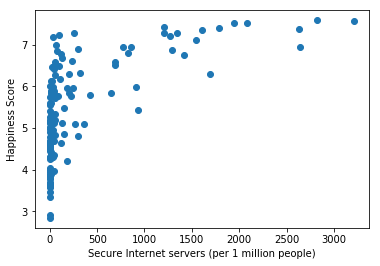

In [73]:
i = 'Secure Internet servers (per 1 million people)'
c = indicators_to_codes[i]
X = df_data_ols.loc[:, c]
plt.plot(X, df_data_ols['Happiness Score'], 'o');
ax = plt.gca()
ax.set_xlabel(i)
ax.set_ylabel('Happiness Score')

Taking the log :

Text(0,0.5,'Happiness Score')

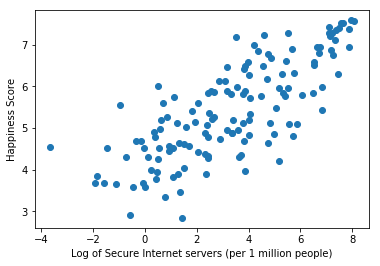

In [74]:
c = indicators_to_codes['Secure Internet servers (per 1 million people)']
X = df_data_ols.loc[:, c]
plt.plot(np.log(X), df_data_ols['Happiness Score'], 'o');
ax = plt.gca()
ax.set_xlabel('Log of ' + str(i))
ax.set_ylabel('Happiness Score')

Interpretation : 
- arrival of internet in a country is correlated to increase in happiness. This can be interpreted as the country being more open to the world and people accessing to eductation and information 
- there is a threshold from where more facilities (here internet server) does not increase happiness

** Same here for maternal mortality : **

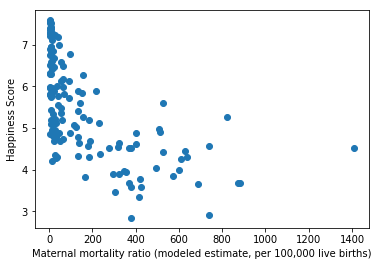

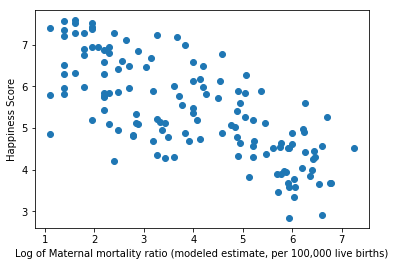

In [75]:
i = 'Maternal mortality ratio (modeled estimate, per 100,000 live births)'
c = indicators_to_codes[i]
X = df_data_ols.loc[:, c]
plt.plot(X, df_data_ols['Happiness Score'], 'o');
ax = plt.gca()
ax.set_xlabel(i)
ax.set_ylabel('Happiness Score')
plt.show()

c = indicators_to_codes['Maternal mortality ratio (modeled estimate, per 100,000 live births)']
X = df_data_ols.loc[:, c]
plt.plot(np.log(X), df_data_ols['Happiness Score'], 'o');
ax = plt.gca()
ax.set_xlabel('Log of ' + str(i))
ax.set_ylabel('Happiness Score')
plt.show()

** Interpretation : **  
Maternal mortality is a proxy for medical facilities and women emancipation.  
We can observe an asymptotic behavior (Happiness Score increase slightly) for mortality > 200.  
This can be explained by the fact that 400 or 4000 death is equaly a sign of bad medical facilities.  
For < 200 deaths, the happiness score increases exponentialy as deaths decrease. This is due to the fact that every death accounts for better medical facilities. Here 150 and 100 deaths may correspond to very different medical level of facilities

** Add log features : **

In [76]:
new_features = ['AG.LND.PRCP.MM',
 'IC.ELC.TIME',
 'IC.TAX.DURS',
 'IT.NET.SECR.P6_log',
 'SH.STA.MMRT_log']

df_data_ols['IT.NET.SECR.P6_log'] = np.log(df_data_ols['IT.NET.SECR.P6'])
df_data_ols['SH.STA.MMRT_log'] = np.log(df_data_ols['SH.STA.MMRT'])

world_map_with_data['IT.NET.SECR.P6_log'] = np.log(world_map_with_data['IT.NET.SECR.P6'])
world_map_with_data['SH.STA.MMRT_log'] = np.log(world_map_with_data['SH.STA.MMRT'])

codes_to_indicators['IT.NET.SECR.P6_log'] = 'Log of' + codes_to_indicators['IT.NET.SECR.P6']
codes_to_indicators['SH.STA.MMRT_log'] = 'Log of' + codes_to_indicators['SH.STA.MMRT']

In [77]:
model = sm.OLS(df_data_ols['Happiness Score'], df_data_ols[new_features + ['const']])
res = model.fit()
print('R squared : ', res.rsquared)
print('R squared adjusted : ', res.rsquared_adj)

R squared :  0.6634080328552506
R squared adjusted :  0.6506583371300707


Cross validation for hyperparameter tuning...
Best MSE :  0.5088185083716771
Best alpha :  0.0010985411419875584
Non zeros coefficients : 
['Average precipitation in depth (mm per year)', 'Time required to get electricity (days)', 'Time to prepare and pay taxes (hours)', 'Log ofSecure Internet servers (per 1 million people)', 'Log ofMaternal mortality ratio (modeled estimate, per 100,000 live births)']
Display maps...


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


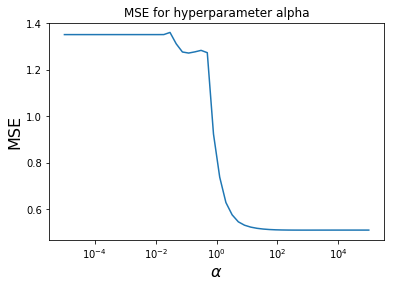

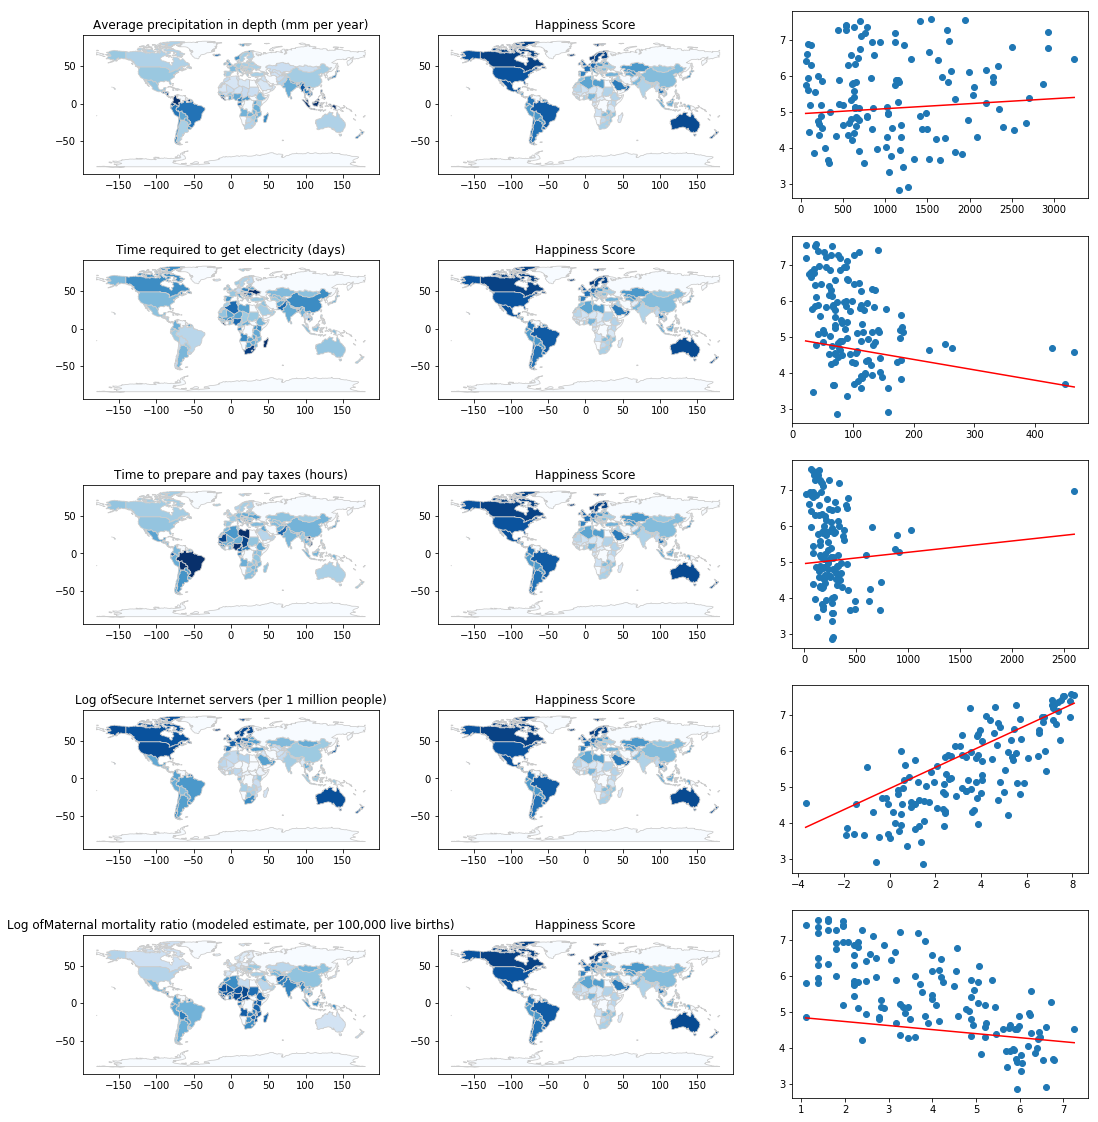

In [78]:
from sklearn.linear_model import LassoCV

bprint('Cross validation for hyperparameter tuning...')
mdl = LassoCV(alphas=np.logspace(-5,5), tol=1, cv=3)

mdl.fit(df_data_ols[new_features], df_data_ols['Happiness Score'])

plt.plot(mdl.alphas, mdl.mse_path_.mean(axis=1));
plt.xscale('log')
plt.title('MSE for hyperparameter alpha')
plt.ylabel('MSE', fontsize=16);
plt.xlabel(r'$\alpha$', fontsize=16);

bprint('Best MSE : ', mdl.mse_path_.mean(axis=1).min())
bprint('Best alpha : ', mdl.alpha_)
bprint('Non zeros coefficients : ')

lasso_codes = [x for x, y in zip(new_features, mdl.coef_) if np.abs(y) > 0.0001]
lasso_idx = [x for x, y in enumerate(mdl.coef_) if np.abs(y) > 0.0001]
lasso_indicators = [codes_to_indicators[x] for x in lasso_codes]
print(lasso_indicators)


bprint('Display maps...')
fig, ax = plt.subplots(len(lasso_codes), 3, figsize=(18, 20));

for i, c in enumerate(lasso_codes):
    
    plot_map(world_map_with_data, c, ax[i][0])

    plot_map(world_map_with_data, 'Happiness Score', ax[i][1])

    X = df_data_ols.loc[:, c]
    ax[i][2].plot(X, df_data_ols['Happiness Score'], 'o')
    xgrid = np.linspace(X.min(), X.max(), 50)
    ax[i][2].plot(xgrid, mdl.intercept_ + mdl.coef_[lasso_idx[i]] * xgrid, 'r')